# Term Deposit Marketing

In this notebook, the following supervised ML models were explored.
- XGBoost
- SMOTE with XGB
- Undersampling with XGB

The class distribution is imbalanced with 92.76% majority class (did not subscribe to term deposit) and 7.24% minority class (subscribed to term deposit).

## Imports

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
import importlib.util

# Load 01_transfxn.py
spec = importlib.util.spec_from_file_location("transfxn", "../src/helper/01_transfxn.py")
transfxn = importlib.util.module_from_spec(spec)
spec.loader.exec_module(transfxn)

# Load 02_ml.py
spec = importlib.util.spec_from_file_location("ml", "../src/helper/02_ml.py")
ml = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ml)

## Load the data

In [3]:
# Load the dataset

file_path = '../data/clean_data.csv'
df = pd.read_csv(file_path)

print('Data size',df.shape)
df.head()

Data size (40000, 14)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,class
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  class      40000 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


## Exploratory Data Analysis

### Class distribution

In [5]:
label_pct = df['class'].value_counts(normalize = True)*100
label_ct =  df['class'].value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values, 
        'percentage': label_pct.values,
    }
)

,labels,count,percentage
0,0,37104,92.76
1,1,2896,7.24


### Descriptive statistics

In [6]:
df.drop('class', axis =1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


### Age Vs Target

- Ages 85, 90 and 95 had 100% Term deposit subcription rate, however there only 3 customers age 85 and one customer each of ages 90 and 95
- Ages 61 to 79 had good amount of subscription rate

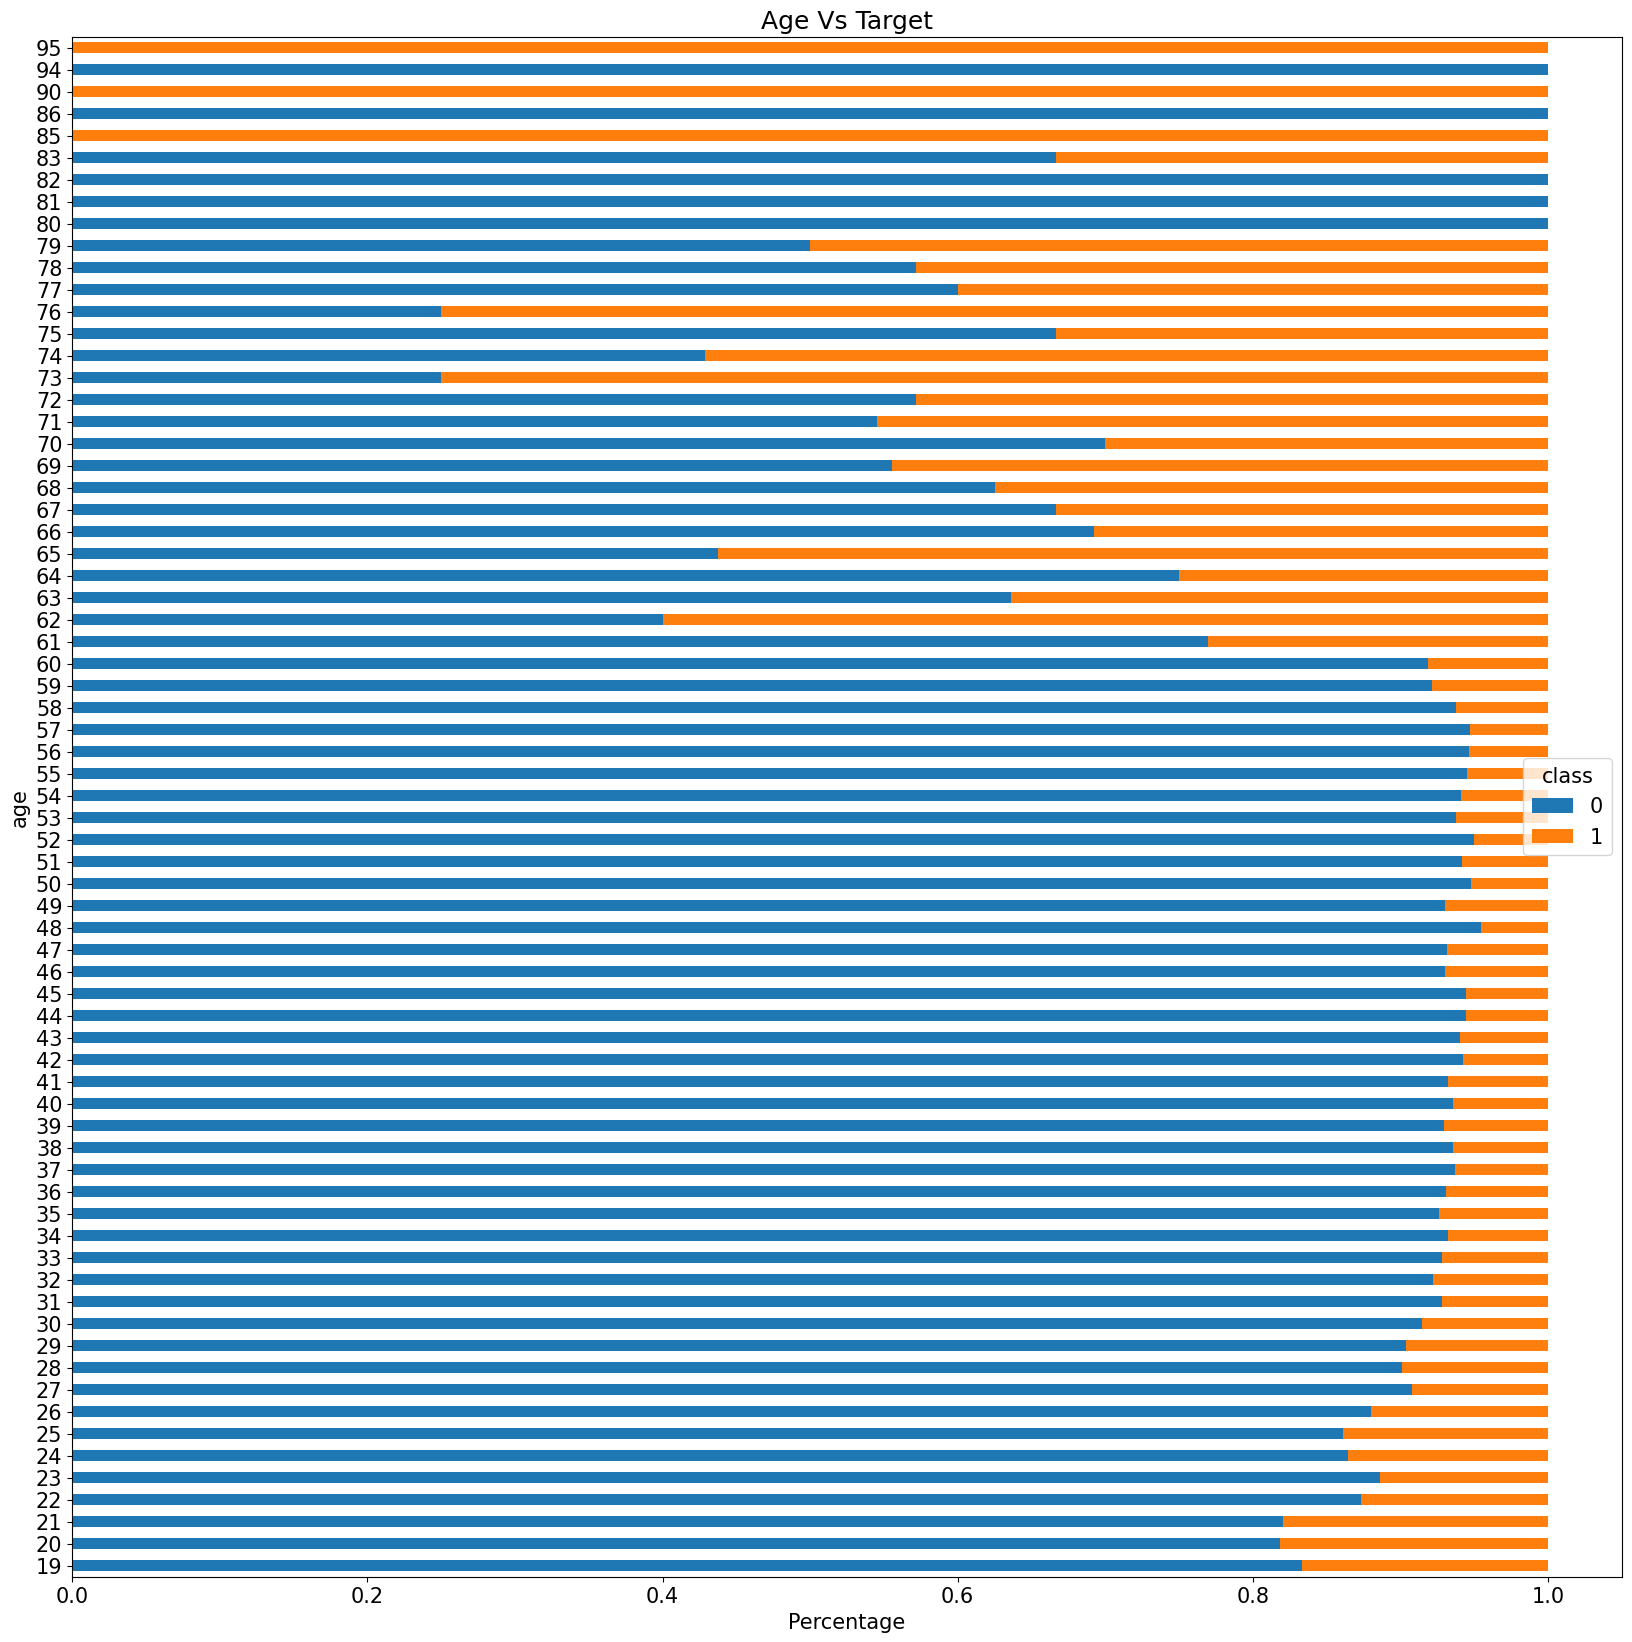

In [7]:
pvt_age = pd.crosstab(index = df['age'], columns = df['class'], normalize= 'index')
pvt_age.plot(kind = 'barh', stacked = True, figsize = (20,20))
plt.xlabel('Percentage')
plt.title('Age Vs Target')
plt.savefig('../image/fig_1.png')
plt.show()

In [8]:
count85 = (df['age'] == 85).sum()
count90 = (df['age'] == 90).sum()
count95 = (df['age'] == 95).sum()
print(f"The count of customers 85 years old is: {count85}")
print(f"The count of customers 90 years old is: {count90}")
print(f"The count of customers 95 years old is: {count95}")

The count of customers 85 years old is: 3
The count of customers 90 years old is: 1
The count of customers 95 years old is: 1


### Housing Vs Target

- Customers without housing has slightly greater chance of subscribing to term deposit

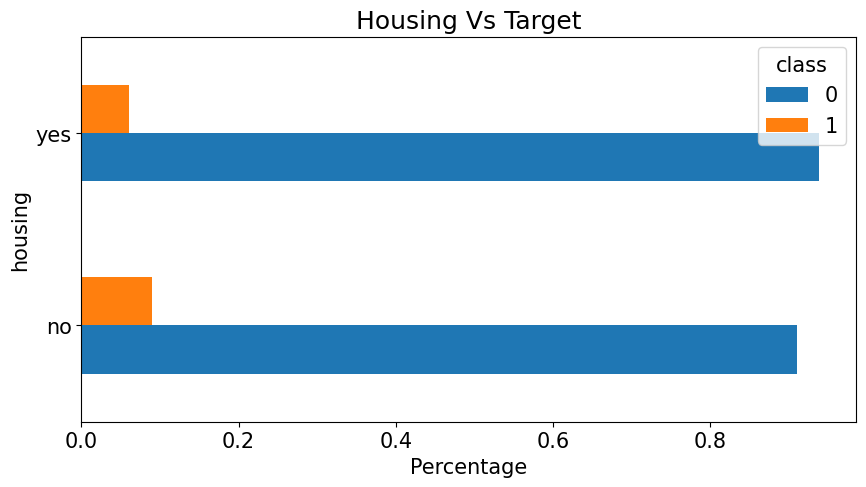

In [9]:
pvt_housing = pd.crosstab(index = df['housing'], columns = df['class'], normalize= 'index')
pvt_housing.plot(kind = 'barh', stacked = False, figsize = (10,5))
plt.xlabel('Percentage')
plt.title('Housing Vs Target')
plt.savefig('../image/fig_2.png')
plt.show()

### Duration Vs Target

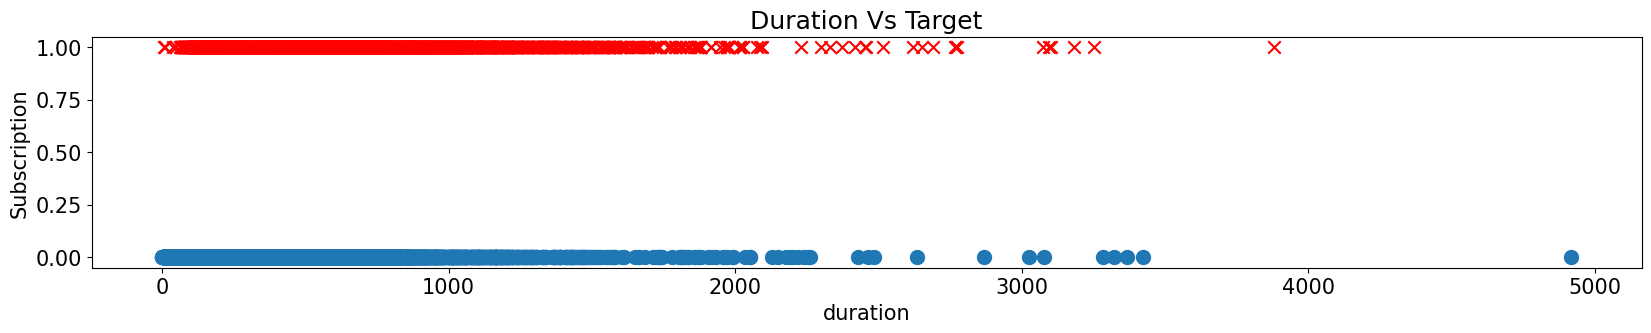

In [10]:
pos = df['class'].to_numpy() == 1
neg = df['class'].to_numpy() == 0
# Target vs features
fig,ax=plt.subplots(1, 1, figsize=(20, 3), sharey=True)
ax.scatter(df["duration"].to_numpy()[pos], df['class'].to_numpy()[pos], marker='x', s=80, c = 'red', label="y=1")
ax.scatter(df["duration"].to_numpy()[neg], df['class'].to_numpy()[neg], marker='o', s=100, label="y=0")
ax.set_xlabel('duration')
ax.set_ylabel("Subscription")
plt.title('Duration Vs Target')
plt.savefig('../image/fig_3.png')
plt.show()

### Term rate per month

- There are more subscribtion between April and August, with the highest rates in may

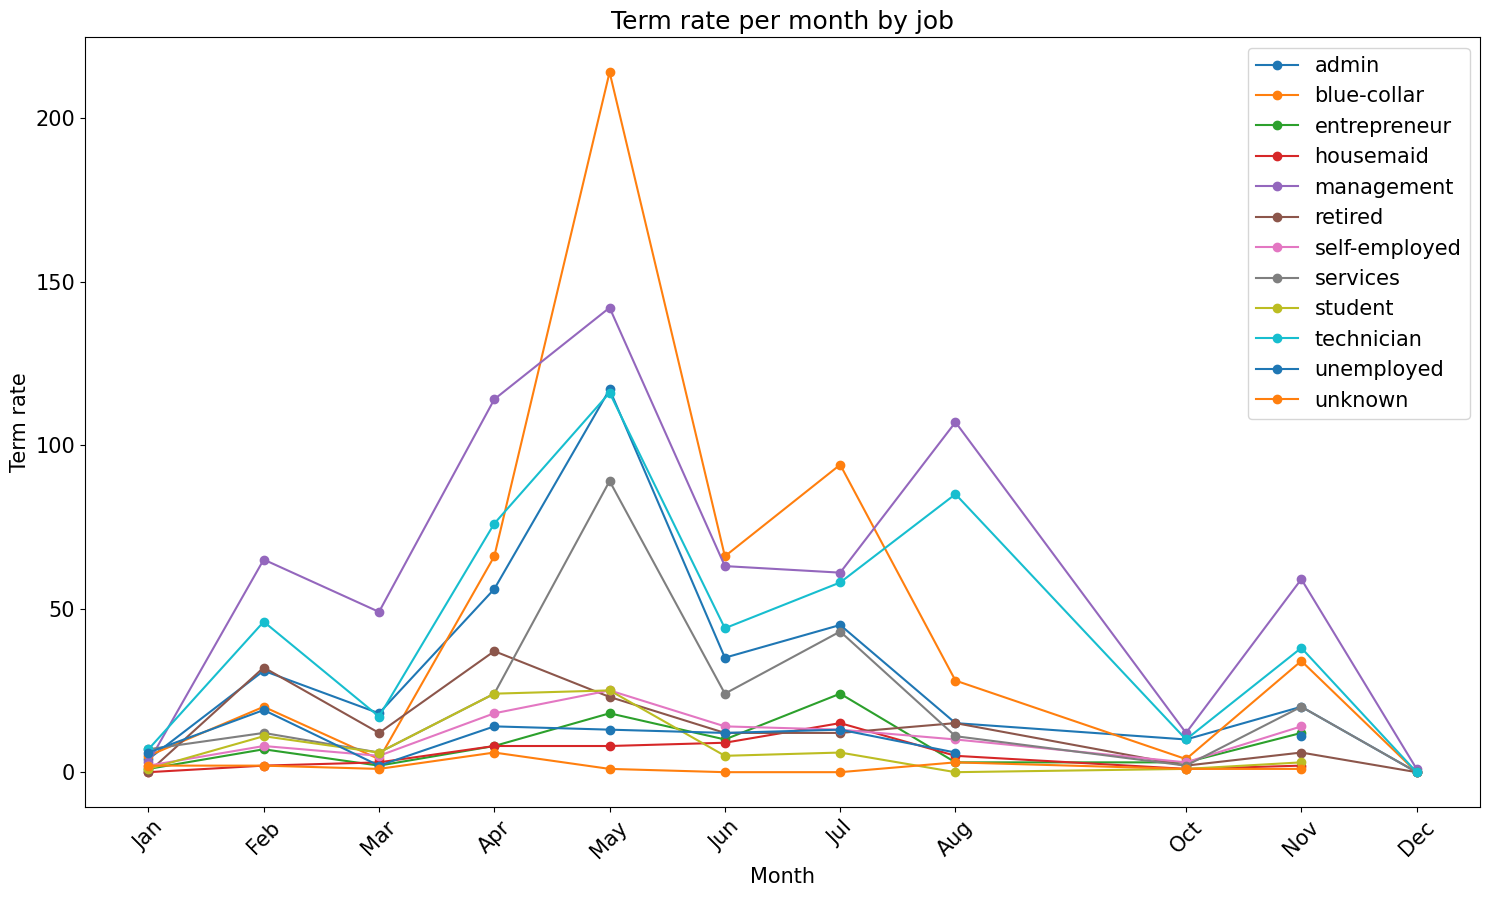

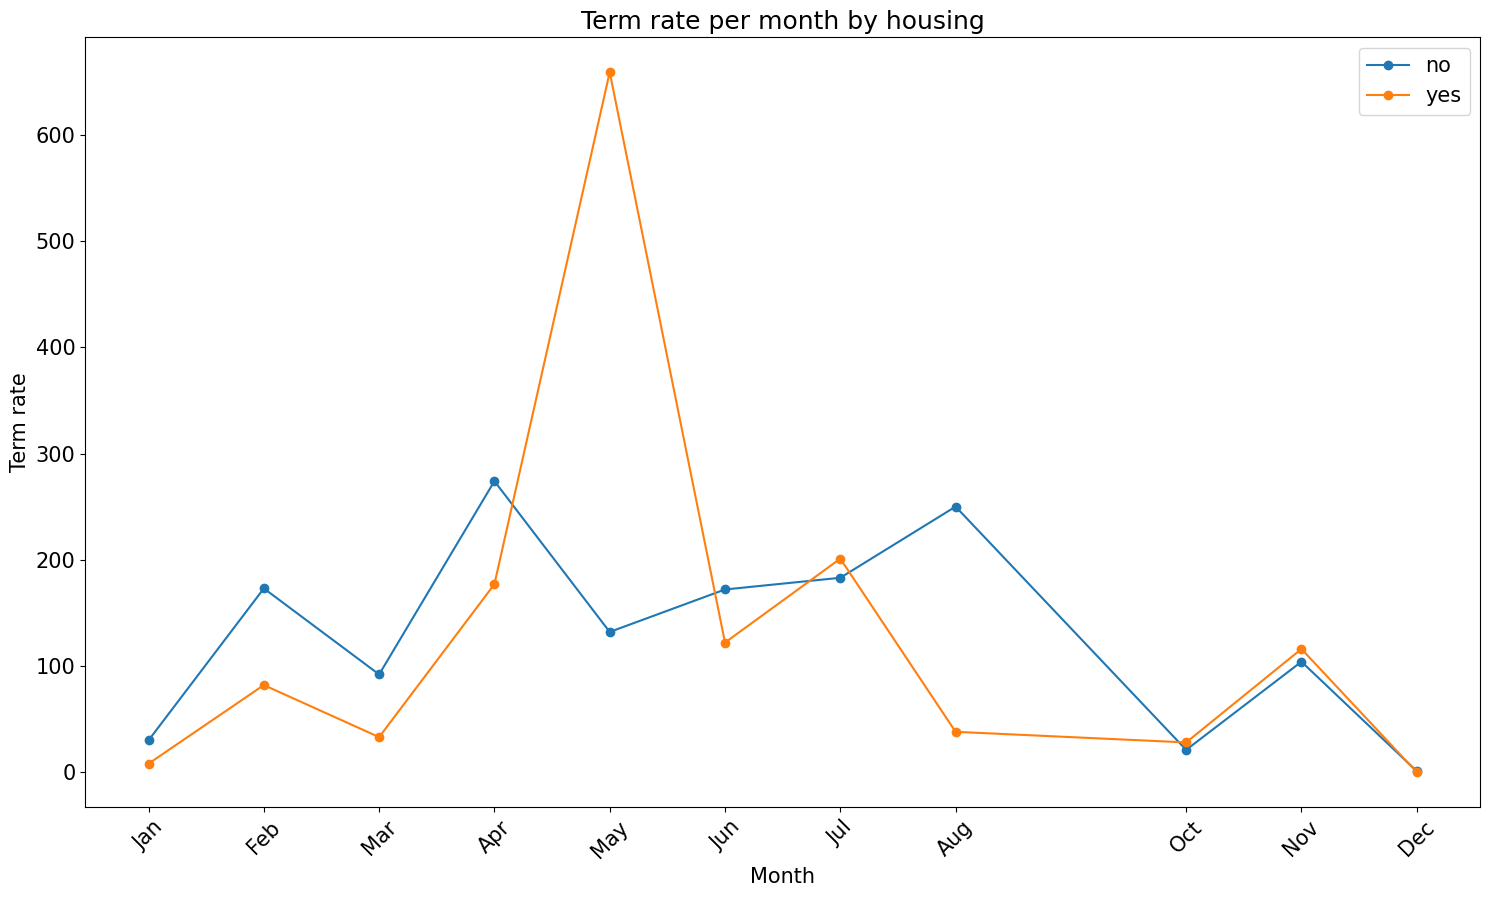

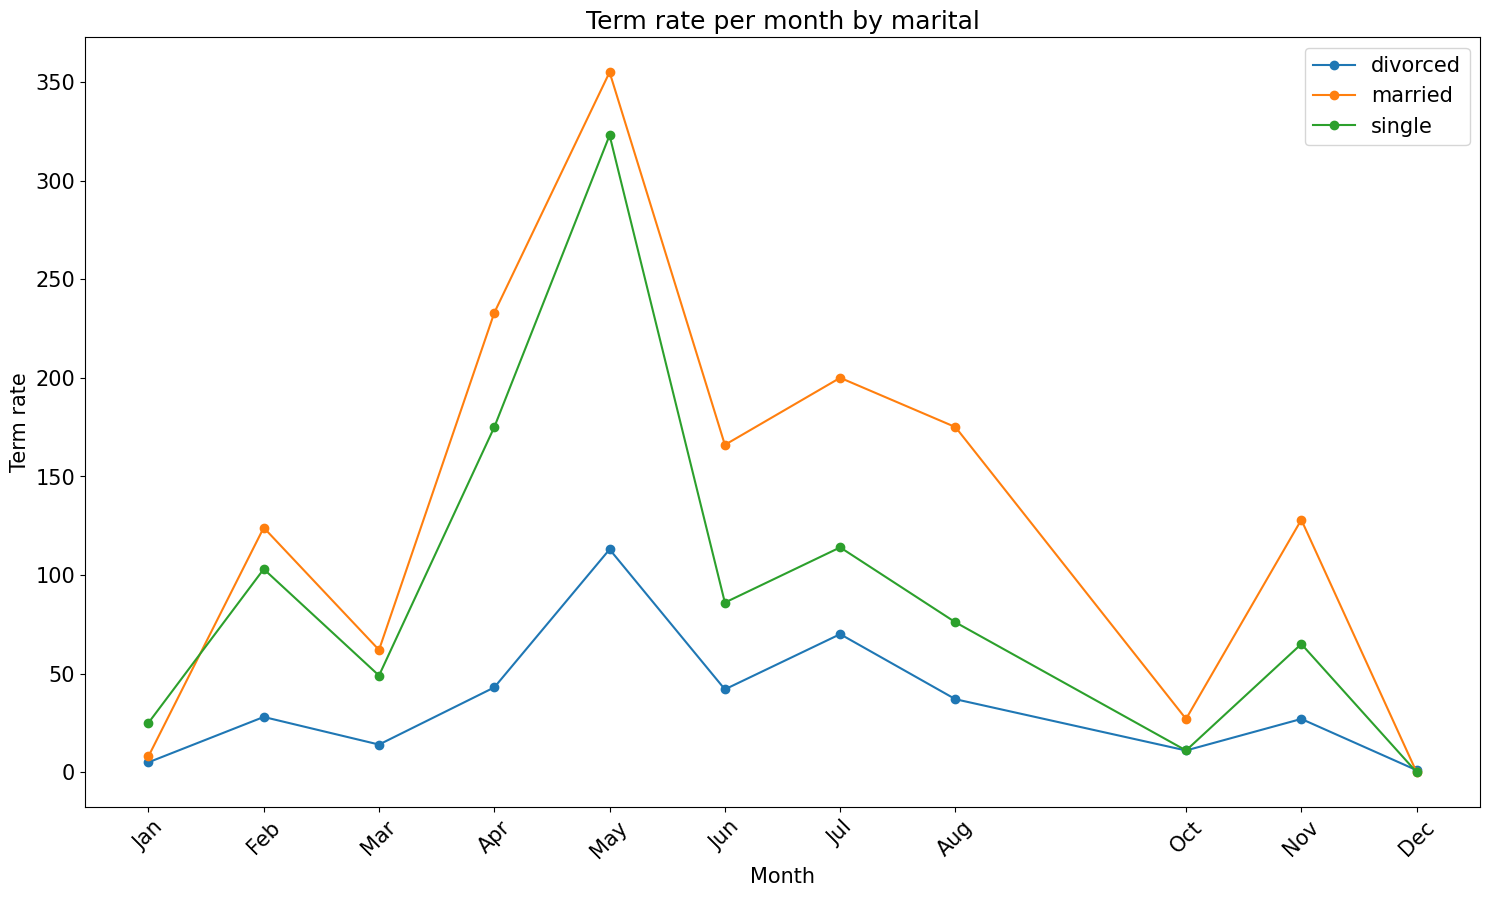

In [11]:
# Change month to integer
month_dict = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 'nov':11, 'dec':12}
df2 = df.copy()
df2['month'].replace(month_dict, inplace = True)

# Pivot tables
pivot_tab_mth1 = df2.pivot_table('class', index = 'month', columns = 'job', aggfunc = 'sum')
pivot_tab_mth2 = df2.pivot_table('class', index = 'month', columns = 'housing', aggfunc = 'sum')
pivot_tab_mth3 = df2.pivot_table('class', index = 'month', columns = 'marital', aggfunc = 'sum')


tick = list(pivot_tab_mth1.index)
labels =['Jan', 'Feb', 'Mar', 'Apr',  'May', 'Jun', 
         'Jul','Aug','Oct', 'Nov','Dec'
        ]


# plots
pivot_tab_mth1.plot(marker = 'o', figsize = (18,10))
plt.xlabel('Month')
plt.ylabel('Term rate')
plt.title('Term rate per month by job')
plt.xticks(tick, labels, rotation = 45)
plt.legend(loc = 0)
plt.savefig('../image/fig_4.png')
plt.show()


pivot_tab_mth2.plot(marker = 'o', figsize = (18,10))
plt.xlabel('Month')
plt.ylabel('Term rate')
plt.title('Term rate per month by housing')
plt.xticks(tick, labels, rotation = 45)
plt.legend(loc = 0)
plt.savefig('../image/fig_5.png')
plt.show()

pivot_tab_mth3.plot(marker = 'o', figsize = (18,10))
plt.xlabel('Month')
plt.ylabel('Term rate')
plt.title('Term rate per month by marital')
plt.xticks(tick, labels, rotation = 45)
plt.legend(loc = 0)
plt.savefig('../image/fig_6.png')
plt.show()

## Create test and train set

In [12]:
# Split feature and target vectors
X = df.drop("class", axis=1)
y = df["class"]

print('Data size:', X.shape, y.shape)

Data size: (40000, 13) (40000,)


Split the data set into 80% training and 20% test set

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, 
                                                    stratify=y)

In [14]:
print(f'Training set size: {X_train.shape, y_train.shape}')
print(f'Test set size: {X_test.shape, y_test.shape}')

Training set size: ((32000, 13), (32000,))
Test set size: ((8000, 13), (8000,))


## Class distribution in training and test sets

In [15]:
print(f'Training set class distribution:\n {(y_train.value_counts()/X_train.shape[0])*100}')
print('--' * 15)
print(f'Test set class distribution:\n {(y_test.value_counts()/X_test.shape[0])*100}')

Training set class distribution:
 class
0    92.759375
1     7.240625
Name: count, dtype: float64
------------------------------
Test set class distribution:
 class
0    92.7625
1     7.2375
Name: count, dtype: float64


## Preprocessing

Data preprocessing involves the following steps.

- Numerical Predictors

    - Impute the missing values with the median
    - Standardize and scale the predictors

- Categorical Predictors

    - Impute the missing values with a constant "NA"
    - One-hot encode the predictors

In [16]:
pipeline = transfxn.TransformationPipeline()

In [17]:
# Preprocessing
X_train_scaled, X_test_scaled, feat_names = pipeline.preprocessing(X_train, X_test)


In [18]:
# Size of the data after pre-processing
print(f'Training set size after pre-processing: {X_train_scaled.shape}')
print(f'Test set size after pre-processing: {X_test_scaled.shape}')

Training set size after pre-processing: (32000, 44)
Test set size after pre-processing: (8000, 44)


In [19]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

## Model Training

In [20]:
model = ml.SupervisedModels()

### Section A-1. XGBoost

In [21]:
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'learning_rate':0.05, 
    'random_state':42,
    'n_jobs':-1,
    'n_estimators':100,
}
              
xgb_clf = xgb.XGBClassifier(**param_dist)
xgb_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(xgb_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='XGBoost Classifier',
                )

Predictions on the training set for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.950562
AUC-ROC: 0.965012
AUC-PR: 0.711919
Predicted classes: [0 1]
Confusion matrix:
 [[29310   373]
 [ 1209  1108]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     29683
           1       0.75      0.48      0.58      2317

    accuracy                           0.95     32000
   macro avg       0.85      0.73      0.78     32000
weighted avg       0.95      0.95      0.95     32000

------------------------------------------------------------


### Section A-2: Cross-validation for XGBoost

In [22]:
model.prediction_cv(xgb_clf, X_train_scaled, y_train, 
                    cv_fold=5, scoring='accuracy',
                    model_nm="XGBoost Classifier",
                   )

5-fold cross-validation for XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.937125 (0.001035)
AUC-ROC: 0.947872
AUC-PR: 0.548370
Predicted classes: [0 1]
Confusion matrix:
 [[29116   567]
 [ 1445   872]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     29683
           1       0.61      0.38      0.46      2317

    accuracy                           0.94     32000
   macro avg       0.78      0.68      0.72     32000
weighted avg       0.93      0.94      0.93     32000

------------------------------------------------------------


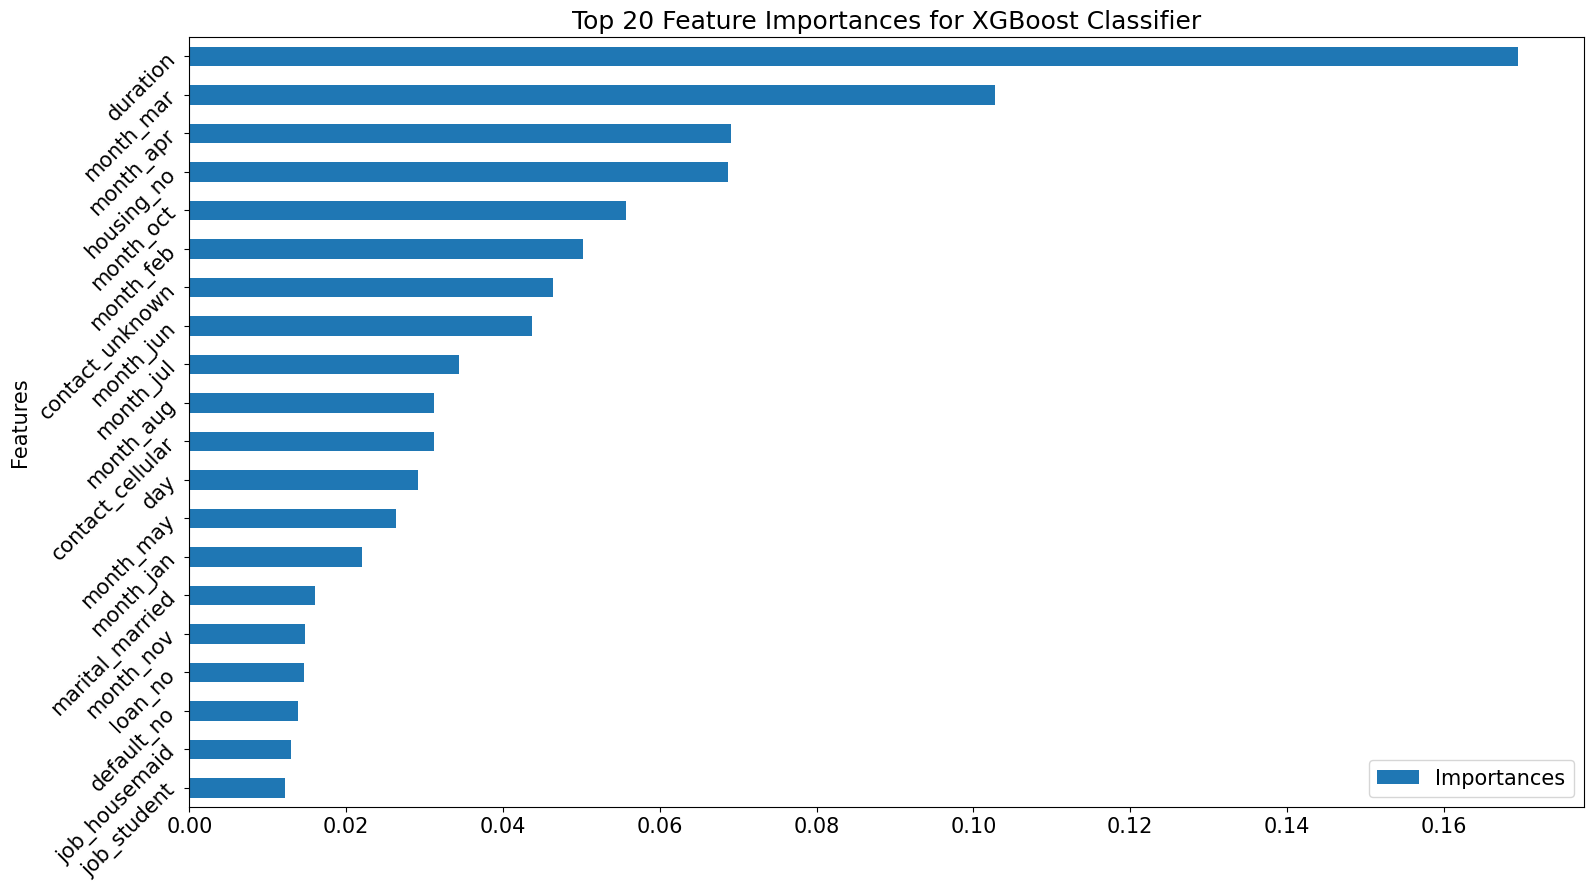

In [23]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
    'Features': feat_names,
    'Importances': xgb_clf.feature_importances_,
    }
)
# Bar plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace=True)
importances_df.tail(20).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 20 Feature Importances for XGBoost Classifier')
plt.savefig('../image/fig_7.png')
plt.show()

### Section A-3. Hyperparameter tuning - XGBoost

optimizing the AUC of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [24]:
# Class ratio of the 
# negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

12.810962451445835

In [25]:
# Range of hyperparameters
params = {'max_depth': range(1,10,2), 
          'min_child_weight': range(1,6,2),
          'gamma':[i/100 for i in range(0,6)],
          'subsample':[i/10 for i in range(5,9)],
          'colsample_bytree': [i/10 for i in range(5,9)],
          'learning_rate': [0.01, 0.02, 0.05, 0.1],
          }

# Randomized search
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'n_estimators':100,
    'scale_pos_weight':class_ratio, 
    'random_state':42,
            }     
xgb_clf = xgb.XGBClassifier(**param_dist)
rsearch_xgb = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params, 
                                  scoring='roc_auc', cv=5, n_jobs=-1, n_iter=200, 
                                  random_state=42, verbose=1
                                )   
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../src/model/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Randomized search best AUC score: 0.9486108092668651
Randomized search best hyperparameters: {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.04, 'colsample_bytree': 0.8}


In [26]:
# Load trained model

xgb_clf = joblib.load('../src/model/xgb_clf.pkl')


### Section B. Resampling Methods

In this section, two resampling methods will be applied to the training set to address class imbalances. 
Nevertheless, the ultimate prediction will be conducted on the unbalanced test set. 
The concept behind resampling is to trick the classifier by utilizing a balanced dataset.

### Section B-1. Under Sampling combined with XGB Classifier

In undersampling, the majority class is reduced such that it matches the minority class

In [27]:
# Under sample the majority class
und = RandomUnderSampler(random_state=42)
X_train_scaled_und, y_train_und = und.fit_resample(X_train_scaled, y_train)

In [28]:
print('Undersampled training data size:', X_train_scaled_und.shape, y_train_und.shape)

Undersampled training data size: (4634, 44) (4634,)


In [29]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [29683  2317]
Undersampled training set class distribution: [2317 2317]


In [30]:
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'learning_rate':0.05, 
    'random_state':42,
    'n_jobs':-1,
    'n_estimators':100,
}
              
xgb_und = xgb.XGBClassifier(**param_dist)
xgb_und.fit(X_train_scaled_und, y_train_und)

# Prediction on the training set
model.prediction(xgb_und, X_train_scaled_und, y_train_und, 
                 subset='training set',
                 model_nm='Undersampling with XGBoost Classifier',
                )

Predictions on the training set for Undersampling with XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.914545
AUC-ROC: 0.970947
AUC-PR: 0.966783
Predicted classes: [0 1]
Confusion matrix:
 [[2024  293]
 [ 103 2214]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91      2317
           1       0.88      0.96      0.92      2317

    accuracy                           0.91      4634
   macro avg       0.92      0.91      0.91      4634
weighted avg       0.92      0.91      0.91      4634

------------------------------------------------------------


In [31]:
# XGBoost Classifier cross-validation on the undersampled dataset
model.prediction_cv(xgb_und, X_train_scaled_und, y_train_und, 
                    cv_fold=5, scoring='accuracy', 
                    model_nm="Undersampling with XGBoost Classifier",
                   )

5-fold cross-validation for Undersampling with XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.880878 (0.007252)
AUC-ROC: 0.933576
AUC-PR: 0.903822
Predicted classes: [0 1]
Confusion matrix:
 [[1948  369]
 [ 183 2134]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.88      2317
           1       0.85      0.92      0.89      2317

    accuracy                           0.88      4634
   macro avg       0.88      0.88      0.88      4634
weighted avg       0.88      0.88      0.88      4634

------------------------------------------------------------


### Section B-2. SMOTE combined with XGB Classifier

In the Synthetic Minority Over Sampling Technique (SMOTE), we create synthetic observations to align with the minority class. 
SMOTE oversamples the minority class within the training set, thus achieving an equal distribution of classes.

In [32]:
# Over sample the minority class
sm = SMOTE(random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_resample(X_train_scaled, y_train)

In [33]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (59366, 44) (59366,)


In [34]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [29683  2317]
SMOTE resampled training set class distribution: [29683 29683]


In [35]:
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'learning_rate':0.05, 
    'random_state':42,
    'n_jobs':-1,
    'n_estimators':100,
}
              
xgb_ovsm = xgb.XGBClassifier(**param_dist)
xgb_ovsm.fit(X_train_scaled_ovsm, y_train_ovsm)

# Prediction on the training set
model.prediction(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, 
                 subset='training set',
                 model_nm='SMOTE with XGBoost Classifier',
                )

Predictions on the training set for SMOTE with XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.938871
AUC-ROC: 0.985348
AUC-PR: 0.984197
Predicted classes: [0 1]
Confusion matrix:
 [[26938  2745]
 [  884 28799]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     29683
           1       0.91      0.97      0.94     29683

    accuracy                           0.94     59366
   macro avg       0.94      0.94      0.94     59366
weighted avg       0.94      0.94      0.94     59366

------------------------------------------------------------


In [36]:
# XGBoost Classifier cross-validation on the SMOTE dataset
model.prediction_cv(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, 
                    cv_fold=5, scoring='accuracy', 
                    model_nm="SMOTE with XGBoost Classifier",
                   )

5-fold cross-validation for SMOTE with XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.933767 (0.008912)
AUC-ROC: 0.982314
AUC-PR: 0.980831
Predicted classes: [0 1]
Confusion matrix:
 [[26801  2882]
 [ 1050 28633]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     29683
           1       0.91      0.96      0.94     29683

    accuracy                           0.93     59366
   macro avg       0.94      0.93      0.93     59366
weighted avg       0.94      0.93      0.93     59366

------------------------------------------------------------


### Section C. Prediction on the Imbalanced Test Set

In this section, we finalize our prediction on the imbalanced dataset following the model's training with the resampling techniques.

### Section C-1. Normal imbalanced model

In [37]:
model.prediction(xgb_clf, X_test_scaled, y_test,
                 subset='test set',
                 model_nm="XGBoost Classifier",
                )

Predictions on the test set for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.879625
AUC-ROC: 0.950125
AUC-PR: 0.570694
Predicted classes: [0 1]
Confusion matrix:
 [[6517  904]
 [  59  520]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93      7421
           1       0.37      0.90      0.52       579

    accuracy                           0.88      8000
   macro avg       0.68      0.89      0.73      8000
weighted avg       0.95      0.88      0.90      8000

------------------------------------------------------------


### Section C-2. Undersampled model

In [38]:
model.prediction(xgb_und, X_test_scaled, y_test,
                subset='test set',
                model_nm="UnderSampling with XGBoost Classifier",
               )

Predictions on the test set for UnderSampling with XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.865625
AUC-ROC: 0.945106
AUC-PR: 0.548123
Predicted classes: [0 1]
Confusion matrix:
 [[6401 1020]
 [  55  524]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      7421
           1       0.34      0.91      0.49       579

    accuracy                           0.87      8000
   macro avg       0.67      0.88      0.71      8000
weighted avg       0.94      0.87      0.89      8000

------------------------------------------------------------


### Section C-3. SMOTE model

In [39]:
model.prediction(xgb_ovsm, X_test_scaled, y_test,
                subset='test set',
                model_nm="SMOTE with XGBoost Classifier",
               )

Predictions on the test set for SMOTE with XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.899250
AUC-ROC: 0.943158
AUC-PR: 0.536332
Predicted classes: [0 1]
Confusion matrix:
 [[6715  706]
 [ 100  479]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94      7421
           1       0.40      0.83      0.54       579

    accuracy                           0.90      8000
   macro avg       0.69      0.87      0.74      8000
weighted avg       0.94      0.90      0.91      8000

------------------------------------------------------------


### Section D. ROC and PR Curves

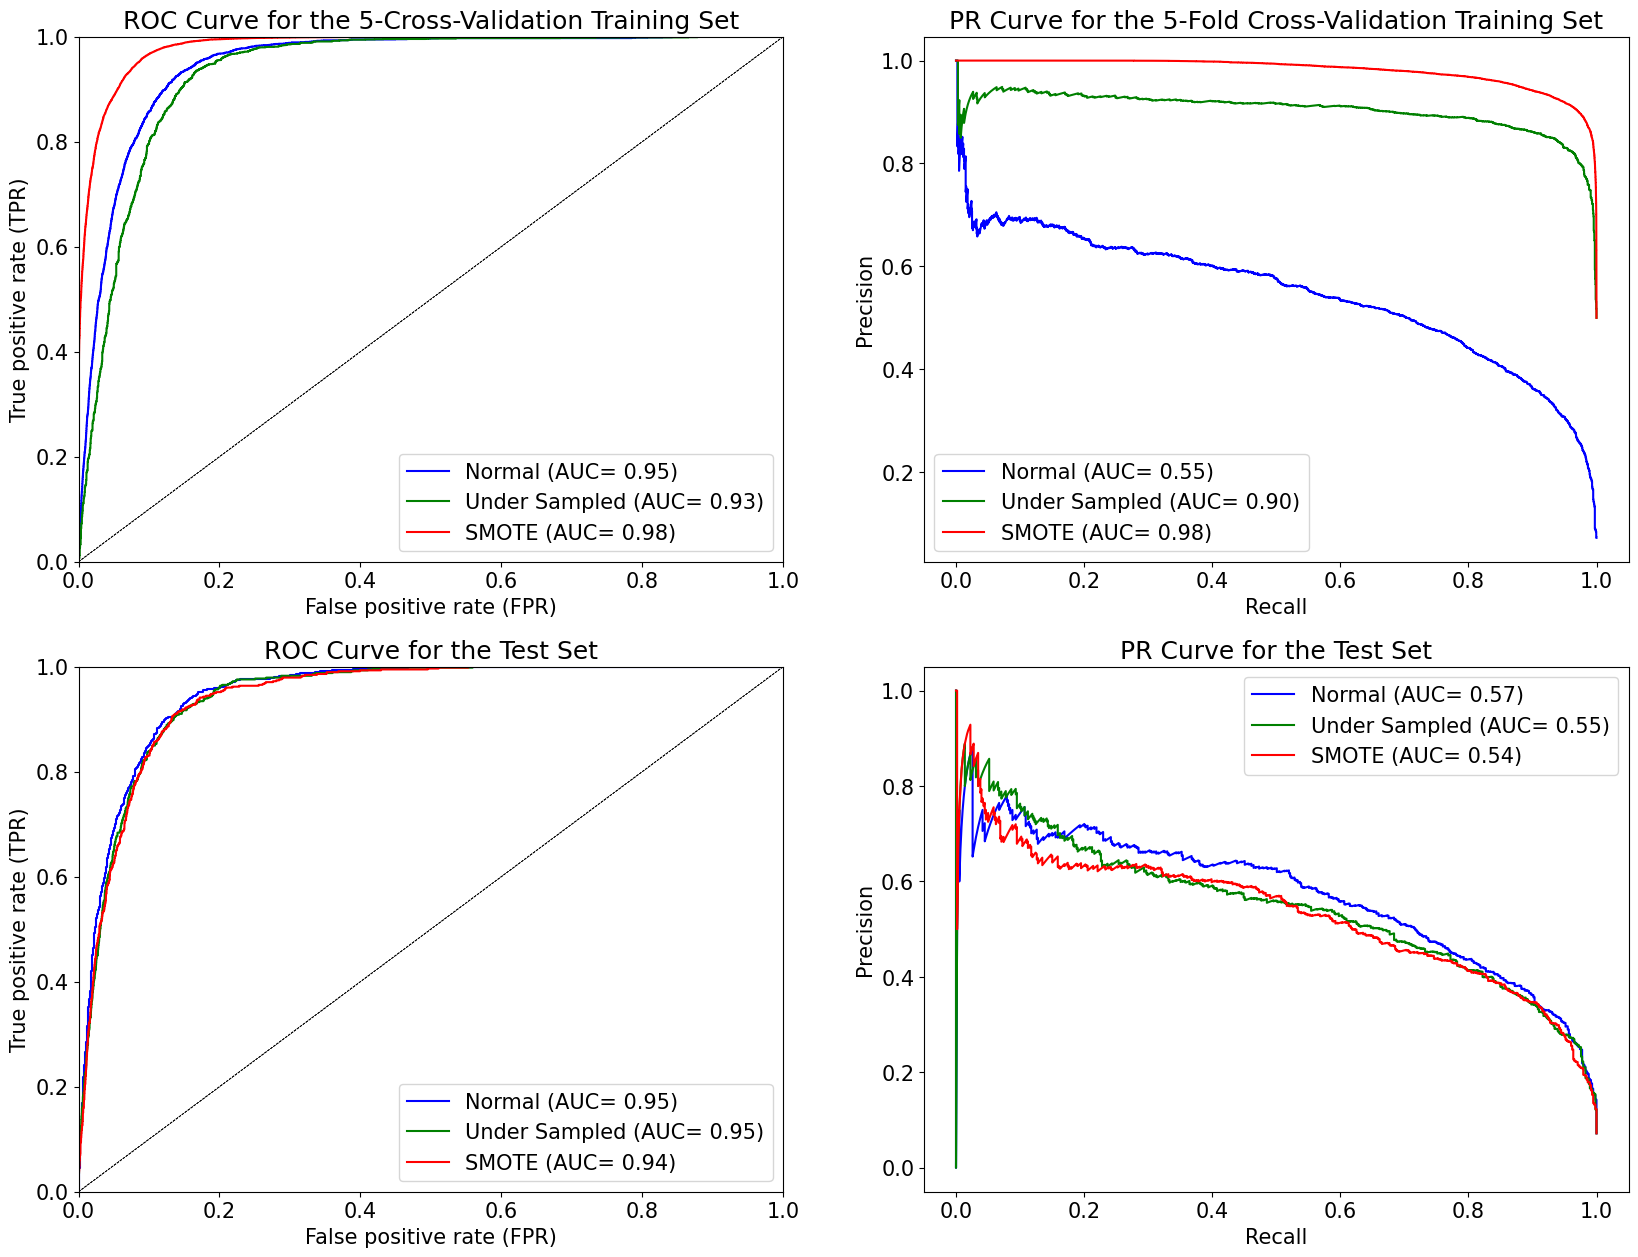

In [40]:
plt.figure(figsize=(20,15))

# Normal imbalanced distribution
model.plot_roc_pr_curves(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                         cv_fold=5, color='b', label='Normal (AUC= %0.2f)',
                        )

# Under Sampled distribution
model.plot_roc_pr_curves(xgb_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, 
                         cv_fold=5, color='g', label='Under Sampled (AUC= %0.2f)',
                        )
                     
# SMOTE distribution
model.plot_roc_pr_curves(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, 
                         cv_fold=5, color='r', label='SMOTE (AUC= %0.2f)',
                        ) 

### Section E. AUC-ROC & AUC-PR for Cross-Validation & Test Sets

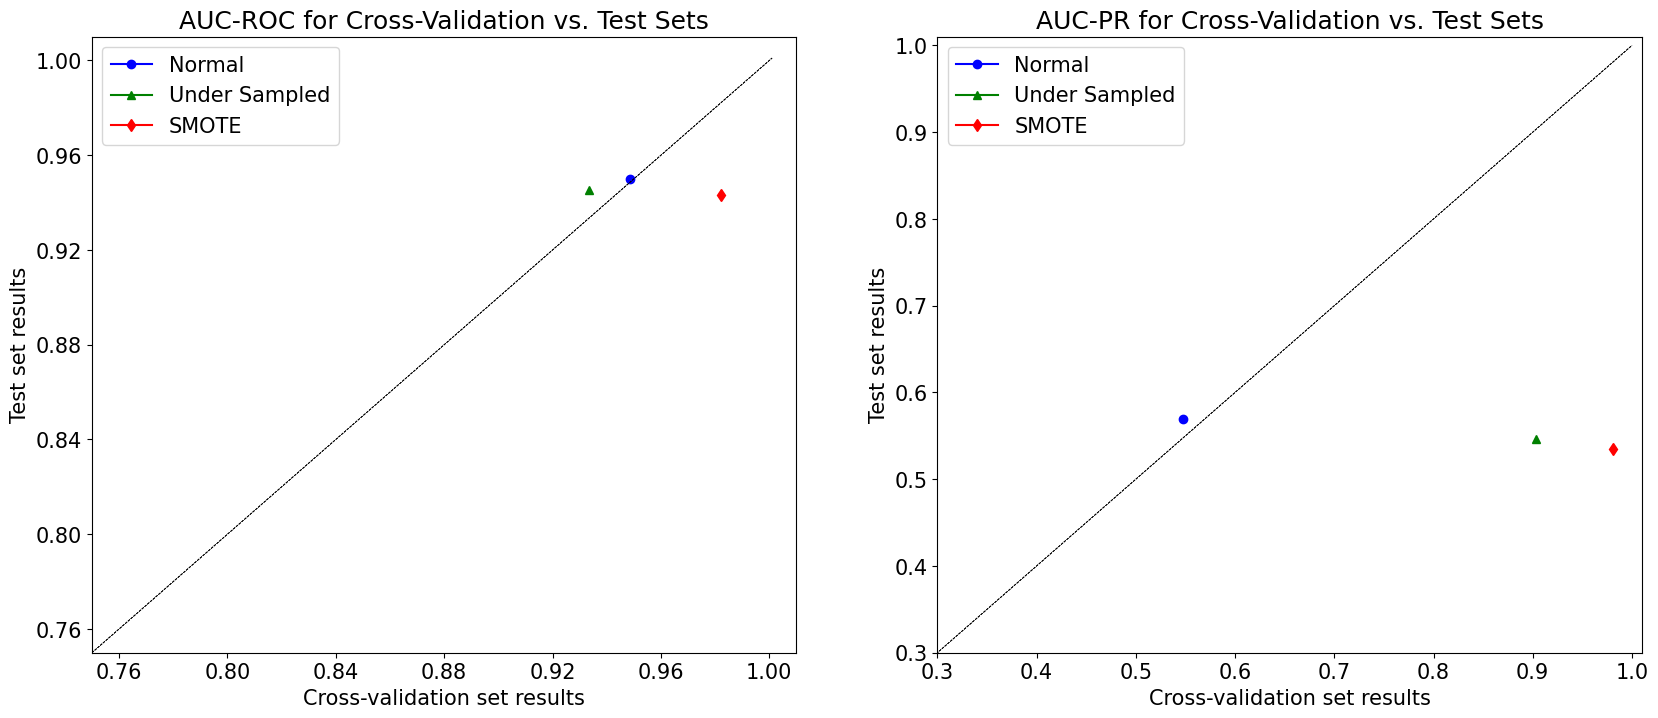

In [41]:
plt.figure(figsize=(20,8))

# Normal imbalanced distribution
model.plot_aucroc_aucpr(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                        cv_fold=5, marker='o', color='b', label='Normal',
                       )

# Under Sampled distribution
model.plot_aucroc_aucpr(xgb_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, 
                        cv_fold=5, marker='^', color='g', label='Under Sampled',
                       )
                     
# SMOTE distribution
model.plot_aucroc_aucpr(xgb_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test,
                        cv_fold=5, marker='d', color='r', label='SMOTE',
                       ) 

## References

[1] https://scikit-learn.org/stable/modules/model_evaluation.html

[2] https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

[3] https://github.com/Owerre/imbalanced-learning/blob/master/imbalanced-learning/notebooks/05_ml_models.ipynb

[4] https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

[5] https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

[6] https://neptune.ai/blog/ml-model-evaluation-and-selection
